In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("matchups_full_2025.csv")
X  = df.filter(like="diff_").to_numpy()
y  = df["label"].to_numpy()
seed_diff = df["diff_seed"].to_numpy()
feat_names = df.filter(like="diff_").columns

# 2. Build feature matrix, labels, and seed_diff array
feature_cols = [c for c in df.columns if c.startswith("diff_")]
sd      = df["diff_seed"].to_numpy()     # for NaiveSeedBaseline

# 3. Stratified random split (80% train / 20% test)
X_train, X_test, y_train, y_test, sd_train, sd_test = train_test_split(
    X, y, sd,
    test_size=0.20,
    stratify=y,
    shuffle=True,
    random_state=42
)



# Custom baselines
def naive_seed_pred(sd):
    """1 if Team A has better (lower) seed, 0 if worse, random on tie."""
    rng   = np.random.RandomState(42)
    pred1 = np.where(sd < 0, 1,
             np.where(sd > 0, 0,
                      rng.randint(0, 2, size=len(sd))))
    return pred1

def random_pred(n, rng):
    return rng.randint(0, 2, size=n)

# Trainable models
log_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, C=1.0, solver="lbfgs")
)

mlp_clf = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(1024, 512, 512, 128, 64),
                  alpha=1e-1,
                  learning_rate_init=1e-2,
                  max_iter=1000,
                  early_stopping=True,
                  random_state=42)
)



# 5‑fold cross‑validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rng = np.random.RandomState(42)

def cv_score(model, X, y):
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy")

scores = {}

# 3.1  Naive seed
fold_acc = []
for train_idx, test_idx in cv.split(X, y):
    y_pred = naive_seed_pred(seed_diff[test_idx])
    fold_acc.append(accuracy_score(y[test_idx], y_pred))
scores["Naive seed"] = np.array(fold_acc)

# 3.2  Random
fold_acc = []
for _, test_idx in cv.split(X, y):
    y_pred = random_pred(len(test_idx), rng)
    fold_acc.append(accuracy_score(y[test_idx], y_pred))
scores["Random"] = np.array(fold_acc)

# 3.3  Logistic
scores["Logistic"] = cv_score(log_clf, X, y)

# 3.4  Neural net
scores["Neural net"] = cv_score(mlp_clf, X, y)

# ------------------------------------------------
# 4.  Fit full models once for introspection
# ------------------------------------------------
log_clf.fit(X, y)
mlp_clf.fit(X, y)        # obtains loss_curve_ via early stopping



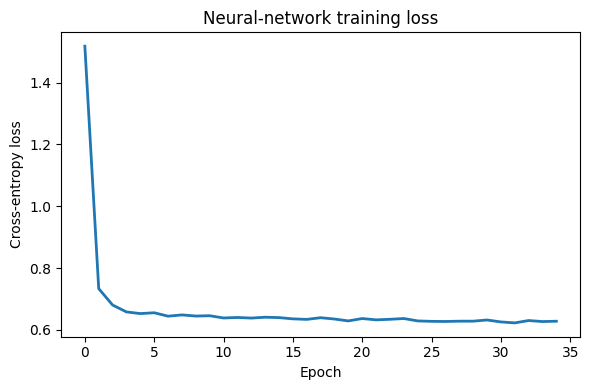

In [36]:
# Plot 1 — Neural‑net training loss
plt.figure(figsize=(6,4))
loss_curve = mlp_clf.named_steps["mlpclassifier"].loss_curve_
plt.plot(loss_curve, lw=2)
plt.title("Neural‑network training loss")
plt.xlabel("Epoch")
plt.ylabel("Cross‑entropy loss")
plt.tight_layout()
plt.savefig("nn_training_loss.png", dpi=300)
plt.show()


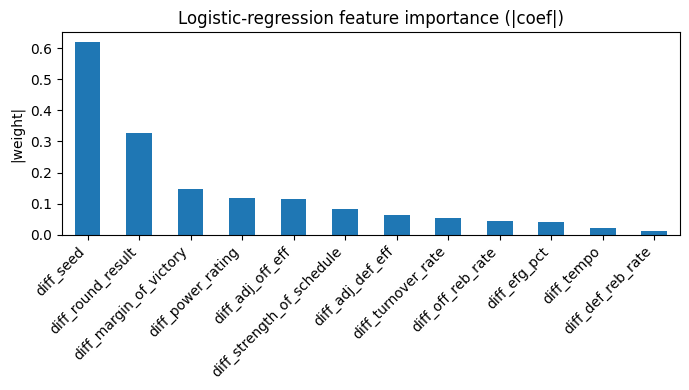

In [37]:

# Plot 2 — Top‑15 logistic feature importances
coef = log_clf.named_steps["logisticregression"].coef_[0]
imp  = pd.Series(np.abs(coef), index=feat_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(7,4))
imp.plot(kind="bar")
plt.title("Logistic‑regression feature importance (|coef|)")
plt.ylabel("|weight|")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("logistic_feature_importance.png", dpi=300)
plt.show()


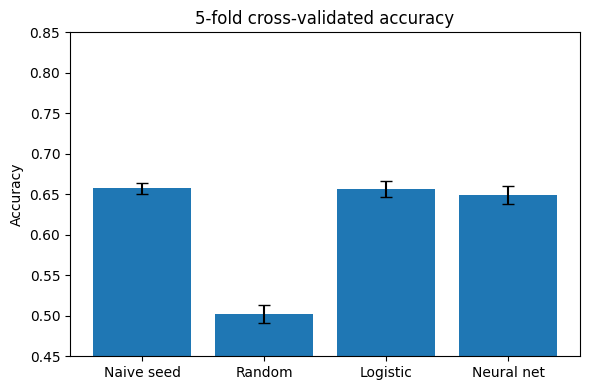

In [38]:

# Plot 3 — Accuracy comparison
model_names = list(scores.keys())
mean_acc = [scores[m].mean() for m in model_names]
std_acc  = [scores[m].std()  for m in model_names]

plt.figure(figsize=(6,4))
plt.bar(model_names, mean_acc, yerr=std_acc, capsize=4)
plt.title("5‑fold cross‑validated accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.45, 0.85)
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png", dpi=300)
plt.show()


In [39]:

print("\n=== CV accuracy ===")
for m in model_names:
    print(f"{m:<12}  {scores[m].mean():.3f} ± {scores[m].std():.3f}")



=== CV accuracy ===
Naive seed    0.657 ± 0.007
Random        0.503 ± 0.011
Logistic      0.657 ± 0.010
Neural net    0.649 ± 0.012


In [33]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

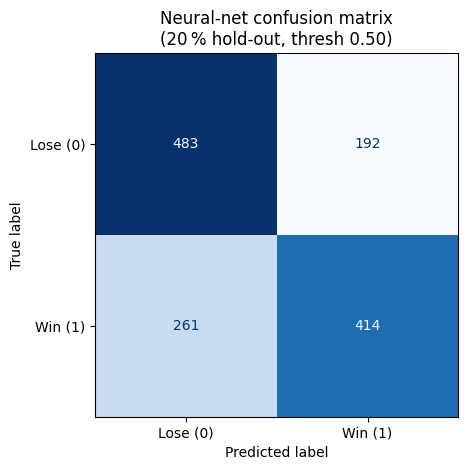

In [27]:
 # ------------------------------------------------------------------
# --- Confusion‑matrix block  (Neural net @ threshold 0.50) --------
# ------------------------------------------------------------------
y_pred = mlp_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Lose (0)","Win (1)"])
disp.plot(cmap="Blues", colorbar=False)
plt.title("Neural‑net confusion matrix\n(20 % hold‑out, thresh 0.50)")
plt.tight_layout()
plt.savefig("confusion_matrix_nn.png", dpi=300)
plt.show()


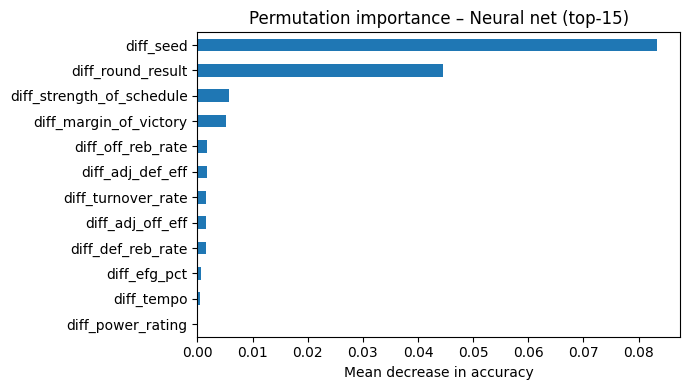

In [28]:

# Permutation feature importance (Neural net) 
perm = permutation_importance(
    mlp_clf, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)
imp_vals = pd.Series(perm.importances_mean, index=feature_cols)
top15 = imp_vals.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(7,4))
top15.sort_values().plot(kind="barh")
plt.xlabel("Mean decrease in accuracy")
plt.title("Permutation importance – Neural net (top‑15)")
plt.tight_layout()
plt.savefig("perm_importance_nn.png", dpi=300)
plt.show()
